# Diffusion-TS Tutorial

## Diffusion-TS: Interpretable Diffusion for General Time Series Generation

This notebook describes the user-guide of a time-series synthetic data generation application using Diffusion-TS framework.

## Necessary packages and functions call

In [2]:
import os
import torch
import numpy as np

from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

c:\Users\Humanophlic\miniconda3\envs\diffusion-ts\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting and Training

### Build dataset and settings

In [6]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = './Config/stocks.yaml'
        self.save_dir = '../../data/diffusion-ts/toy_exp' 
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = build_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)

In [7]:
torch.cuda.is_available()

True

In [7]:
# Load checkpoint
trainer.load(10)

### Training models

In [8]:
trainer.train()

loss: 0.072077: 100%|██████████| 10000/10000 [04:10<00:00, 39.99it/s]

training complete


## Inference and Visualizations

### Sampling

In [10]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
dataset_name = dataset.name
ori_data = np.load(os.path.join(dataset.dir, f"{dataset_name}_norm_truth_{seq_length}_train.npy"))  # Uncomment the line if dataset other than Sine is used.

fake_data_path = os.path.join(args.save_dir, f'ddpm_fake_{dataset_name}.npy')
if os.path.exists(fake_data_path):
    fake_data = np.load(fake_data_path)
else:
    fake_data = trainer.sample(num=len(dataset), size_every=2001, shape=[seq_length, feature_dim])
    if dataset.auto_norm:
        fake_data = unnormalize_to_zero_to_one(fake_data)
        np.save(os.path.join(args.save_dir, f'ddpm_fake_{dataset_name}.npy'), fake_data)

sampling loop time step: 100%|██████████| 500/500 [00:07<00:00, 70.10it/s]


### Visualization

We visualize the original and synthetic data distributions using PCA, tSNE and Density analysis.

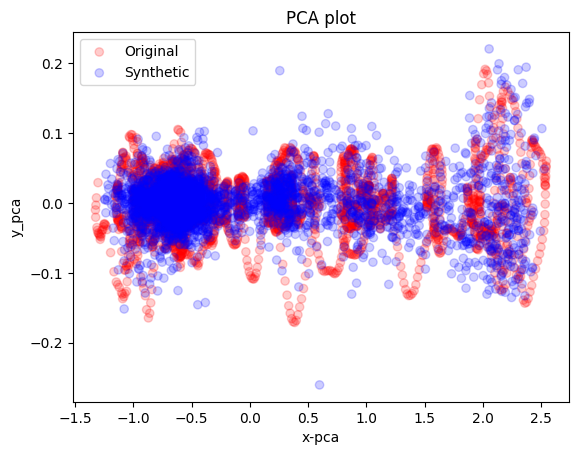

In [11]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='pca', compare=ori_data.shape[0])

c:\Users\Humanophlic\miniconda3\envs\diffusion-ts\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Humanophlic\miniconda3\envs\diffusion-ts\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7324 samples in 0.000s...
[t-SNE] Computed neighbors for 7324 samples in 0.384s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7324
[t-SNE] Computed conditional probabilities for sample 2000 / 7324
[t-SNE] Computed conditional probabilities for sample 3000 / 7324
[t-SNE] Computed conditional probabilities for sample 4000 / 7324
[t-SNE] Computed conditional probabilities for sample 5000 / 7324
[t-SNE] Computed conditional probabilities for sample 6000 / 7324
[t-SNE] Computed conditional probabilities for sample 7000 / 7324
[t-SNE] Computed conditional probabilities for sample 7324 / 7324
[t-SNE] Mean sigma: 0.015674
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.756851
[t-SNE] KL divergence after 300 iterations: 1.881029


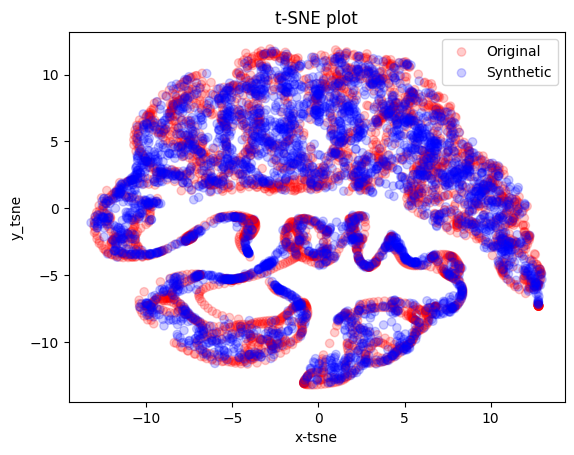

In [12]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='tsne', compare=ori_data.shape[0])

c:\Users\Humanophlic\repos\constrainted-tsg-for-iot\code\Diffusion-TS\Utils\metric_utils.py:157: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
c:\Users\Humanophlic\repos\constrainted-tsg-for-iot\code\Diffusion-TS\Utils\metric_utils.py:158: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new funct

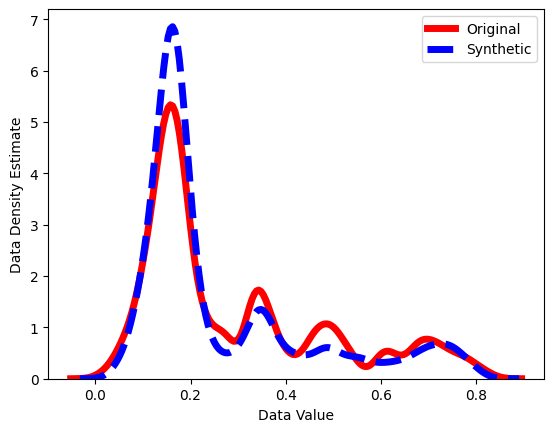

In [13]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='kernel', compare=ori_data.shape[0])